<h1>Basic Low Pass Filtering in Python</h1>

This is the exercise in Lab 5 of CM2015 Project Carrier Course, Part 1 at KTH Royal Institute of Technology.

You are expected to go through this material, play around with the examples, answer the questions, and make a report about your findings. The report should explain your answers using text, code snippets, and/or graphs. The report is then uploaded into Canvas. You are expected to work on your own in this exercise.

This is an Jupyter notebook. If you are looking at it in a non-interactive viewer, you should switch to mybinder.org instead. You can use this link: https://mybinder.org/v2/gh/martinjnl/medsigproc.git/HEAD?labpath=LPFilter.ipynb

Another option is to run it in Microsoft Visual Code on your own PC/mac. But then you need to download Python and Jupyter add-ons as well. Information is available if you search on the Internet.

To run the code in the notebook, you mark the code block and press the 'Play'-button above. The code will execute and the results (if any), will be displayed below. The code executes on a back-end server and if you are inactive for too long, the execution kernel may stop. If that happens, restart the kernel (Python3) and execute the code block. Also note that subsequent code blocks may depend on earlier blocks, so need to execute them one by one in order for everything to work smoothly.

This Jupyter notebook uses Python, Numpy, Matplotlib, and sometimes SciPy. To use these packages we need to import them first.

In [2]:
import numpy as np
import scipy, math
import matplotlib.pyplot as plt

But before we start, we need to get some signals to work with. This can be done by sampling a signal using the PPG-sensor and the Micro:Bit that we used in Lab 1. But in this example, we will just download a sample from the <a href="https://physionet.org/content/mimic3wdb/1.0/">MIMIC-III waveform database</a>.  We used record 36/3600293 and the PLETH signal from [21:41:34.280] to [21:41:35.272]. We have a total sample length of 125 samples. Since the sample frequency is 125 Hz, we have 1 second of recorded data.

In [4]:
signal = [1.070, 1.070, 1.073, 1.077, 1.077, 1.076, 1.076, 1.076, 1.076, 1.076, 1.076, 1.076, 1.076, 1.076, 1.078,
          1.082, 1.085, 1.087, 1.089, 1.091, 1.095, 1.099, 1.103, 1.107, 1.109, 1.109, 1.111, 1.118, 1.133, 1.162,
          1.215, 1.296, 1.409, 1.547, 1.709, 1.882, 2.056, 2.220, 2.367, 2.478, 2.564, 2.644, 2.713, 2.768, 2.812,
          2.847, 2.873, 2.893, 2.908, 2.918, 2.925, 2.928, 2.923, 2.912, 2.903, 2.893, 2.881, 2.863, 2.841, 2.813,
          2.782, 2.747, 2.706, 2.660, 2.613, 2.562, 2.503, 2.435, 2.358, 2.275, 2.188, 2.101, 2.016, 1.935, 1.861,
          1.798, 1.743, 1.701, 1.669, 1.638, 1.610, 1.585, 1.561, 1.538, 1.515, 1.494, 1.473, 1.453, 1.431, 1.413,
          1.396, 1.377, 1.359, 1.339, 1.320, 1.300, 1.282, 1.265, 1.249, 1.234, 1.219, 1.206, 1.196, 1.189, 1.178,
          1.167, 1.156, 1.147, 1.137, 1.129, 1.123, 1.117, 1.112, 1.108, 1.106, 1.106, 1.103, 1.100, 1.096, 1.091,
          1.087, 1.084, 1.082, 1.081, 1.081]
print(len(signal))

125


It is always useful to first visually inspect the signal. So let's do that!

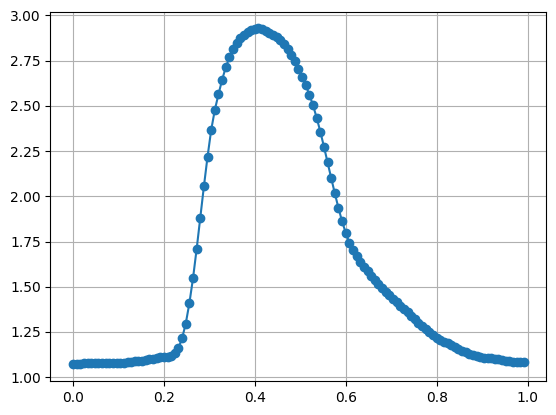

In [5]:
X = np.arange(len(signal)) / 125.0

plt.plot(X,signal,'o-')
plt.grid()
plt.show()

However, let's assume the signal is infinite and repeat itself over and over again. This is very useful in signal processing. Hence, we can repeat the signal three times and use this for our further analysis.

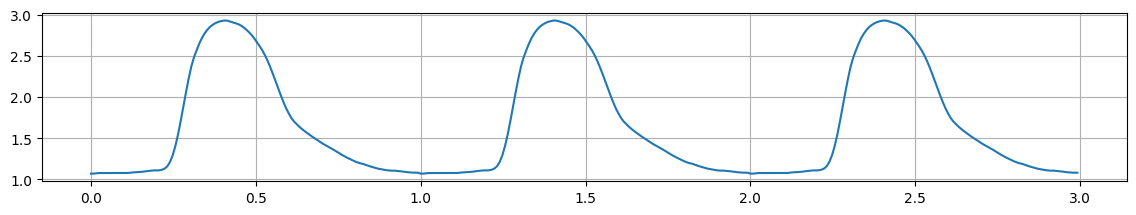

In [6]:
S = np.array(signal + signal + signal)
X = np.arange(len(S)) / 125.0

fig = plt.figure(figsize=(14,6))
plt.axes().set_aspect(0.25)
plt.plot(X,S,'-')
plt.grid()
plt.show()

## Filtering

In lab 1, we used the EWMA filter to try to obtain a good estimate of the current average value.

$$ y_n = \alpha x_n + (1-\alpha) y_{n-1}$$

where $x_n$ is the input signal value, and $y_n$ is the output signal value. The EWMA is one form an IIR filter, where IIR stands for infinite impulse response.

An alternative is to calculate the moving average over a few past samples, known as a window:

$$ y_n = \frac{1}{M} \sum_{k=0}^{M-1} x_{n-k} $$

where $M$ is the size of the window, also known as the number of taps. Let's try this in the code for $M=50$.

If we take the first 50 values from $S$ and then sum them up and divide by 50, we obtain $y_{50}$. In python, we can do this with this line:

In [7]:
np.sum(S[0:50])/50

np.float64(1.5765600000000004)

S[0:50] extracts the 50 first values of the list/array. np.sum() calculates the sum of an array or list.

The next step is to do it for S[1:51], S[2:52], and so on. If we do it as a loop, we need to take care of the boundaries so that our output signal has the same length for plotting. Then, we just plot the results again:

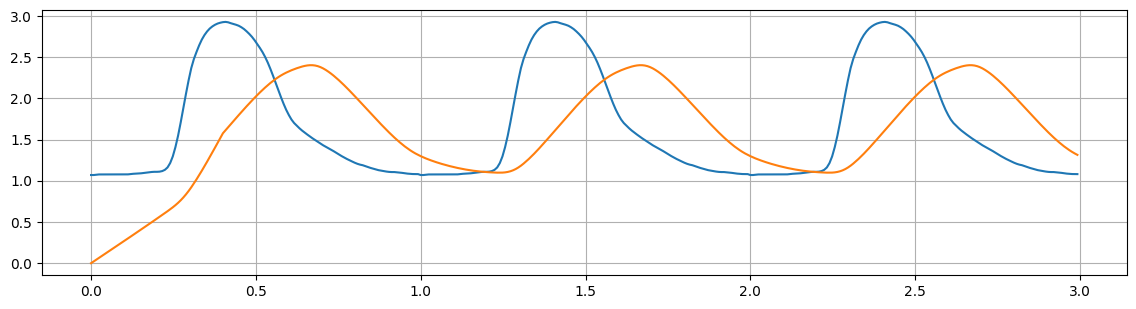

In [8]:
M=50

y = []
for i in range(len(S)):
    start_idx = max(0, i-M)  # If less than zero, set it to zero.
    stop_idx = i
    yn = sum(S[start_idx:stop_idx])/float(M)
    y.append(yn)

#y = y[int(M/2):]   # Move it 25 steps to the left to align better
#y += [0]*int(M/2)  # We need to pad with zeroes in the end.

fig = plt.figure(figsize=(14,6))
plt.axes().set_aspect(0.25)
plt.plot(X,S,'-')
plt.plot(X,y,'-')
plt.grid()
plt.show()

As can be seen in the figure, the filtered curve is more like an average, but not quite since our window is too small. Furthermore, we can see a delay in the results. This is known as a filtering delay (or processing delay). We can solve this delay by shifting the curve to the left. The best is 25 steps, since the average point is then based on 25 values to the left and 25 values to the right. This can be done on pre-recorded data, but not on live data unless we buffer 25 values.

In the code above, you can shift the curve to the left by uncommenting the two lines in the middle.

Also note what happens at the edge of the curve. There are many different strategies to handle the missing values of the original signal. In the code above, we actually use two different methods; one at the beginning and another one at the end.

**answer A**: Move the filtered curve so that it aligns for the unfiltered curve. Put the resulting graph in your report.

**answer B**: To get a flat line on the average, what M do we need? What happens if M is larger than that? Show some example plots in your report. Mark them with the used M.

## General FIR Filters

A moving average filter is a type of Finite Impulse Response (FIR) filter, where all values in the window have the same weight. A generalized FIR filter have the following form:
    
$$ y_n = \sum_{k=0}^{M-1} h_k x_{n-k} $$

where $h_k$ are the filter coefficients. If we set $h_k = 1/M$ for all $0 \leq k < M$, we obtain a moving average. The figure below show how we can calculate the next output value of the filter if $M=4$ and $h_k$ is [0.1 1.0 0.1 0.1]. Note how we need to reverse the list $h_k$ in the figure, i.e., $h_0$ is the right most value.

![FIR](https://github.com/martinjnl/medsigproc/blob/main/imgs/Fig1.png?raw=1)

It almost as simple to implement this in the code as the moving average. We replace the sum with a matrix multiplication (the dot product) as in the code below. Here we choose $M=2$ and $h_0 = 1$ and $h_1 = -1$.

**answer C**: Can you see what filter we have implemented? **Hint**: Does it match any formulas from your basic calculus course? Note how it crosses the zero line exactly at time same time as the signal reaches its peak.

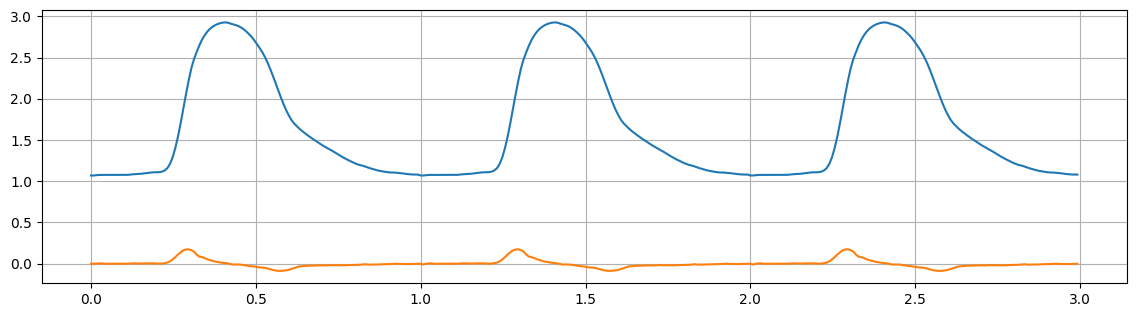

In [9]:
h = np.array([1,-1])

y = [0]*len(h)  # We pad the beginning this time
for i in range(len(h),len(S)):
    start_idx = i-len(h)
    stop_idx = i
    yn = np.dot(S[start_idx:stop_idx], np.flip(h))
    y.append(yn)

#y = y[int(len(h)/2):]     # Move it M/2 steps to the left to align better
#y += [0]*int(len(h)/2)  # We need to pad with zeroes in the end.

fig = plt.figure(figsize=(14,6))
plt.axes().set_aspect(0.25)
plt.plot(X, S, '-')
plt.plot(X, y, '-')
plt.grid()
plt.show()

It is advised that you play around with different configuration of $h$. Here are some examples to try:

In [10]:
h = np.array([10])
h = np.array([-1])
h = np.ones(50)/50
h = np.array([10,0,0,0,-10])
h = np.array([0,0,0,0,0,0,0,1])

np.ones(M) creates an array of size 50 with the value "1.0" in every cell.

**answer D**: For the examples above, how can we best describe them?

**answer E**: Try some more arrays of your own.

Note: If the sum of all $h_k$ is not equal 1, we may have amplification or attenuation.

## Convolution

We have now done the calculation by creating a for-loop. However, there is a mathematical operation to do this. It is known as convolution and usually is denoted by an asterix ($*$). Convolution is defined as follows:

$$ (x * h)[n] = \sum_m x[m]h[n-m] $$

for valid values of $x[\cdot]$ and $h[\cdot]$.  We can use this operation in numpy if we reverse the order of the elements in $h$, which we do with `flip()` as shown below. As you can see, we obtain the same results with the exception of the border effects. In the remain parts of this tutorial, we will continue to use the convolution instead, since it is more compact (and more efficient).

**Note**: It is also possible to use the scipy filter functions, such as `scipy.signal.lfilter(np.flip(h), [1], x)`.

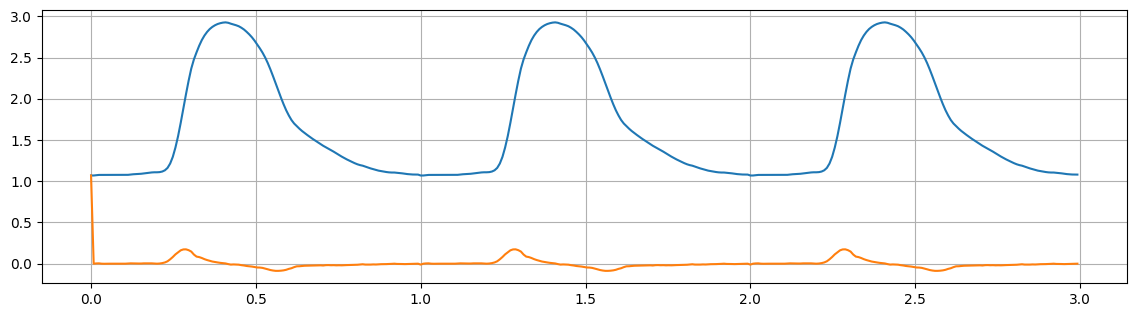

In [11]:
h = np.array([-1,1])

y = np.convolve(S, np.flip(h), mode='same')

fig = plt.figure(figsize=(14,6))
plt.axes().set_aspect(0.25)
plt.plot(X,S,'-')
plt.plot(X,y,'-')
plt.grid()
plt.show()

## Noise

Now, let's add some artificial noise and see if we can filter it out. In this example, we add some 40 Hz noise and some 15 Hz noise with quite small amplitude in comparison to the real signal.

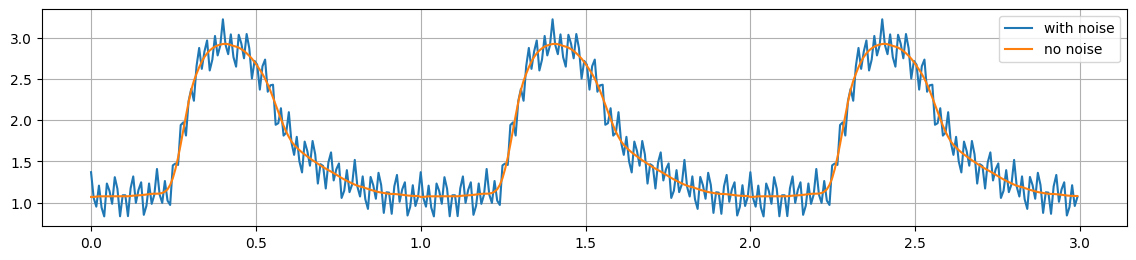

In [12]:
f=40 #Hz
N = 0.2*np.cos(2*np.pi*f*X)
f=15
N += 0.1*np.cos(2*np.pi*f*X)

# Draw the signal with and without noise
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.set_aspect(0.25)
plt.plot(X, S+N, '-', label='with noise')
plt.plot(X, S, '-', label='no noise')
ax.legend(loc='upper right')
plt.grid()
plt.show()

So how should we filter out the noise? Let's apply the FIR filter again. Just try the moving average with $M=3$ below and see what happens.

**answer F**: Try to use a larger window. How large window do you need before the noise is almost gone?

**answer G**: Can you reduce the window size and find a better filter by choosing other $h_k$ values? Hint: Look at the sinc-function or the Hann-function.

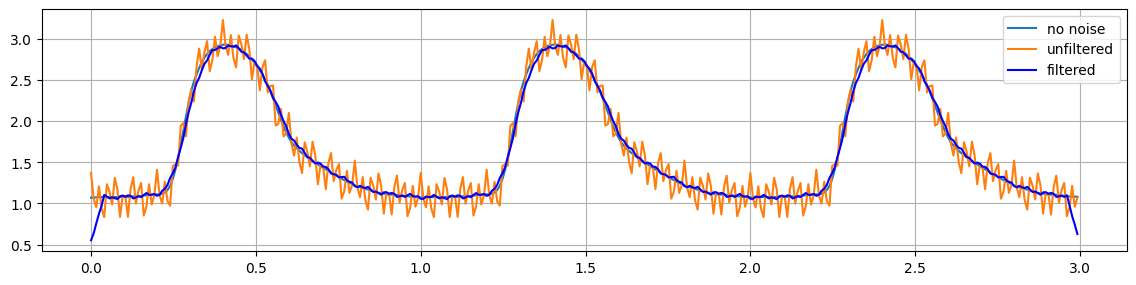

In [13]:
#h = np.array([1,1,1])/3
h = np.array(np.ones(10)/10)

y = np.convolve(S+N, h, mode='same')

# Draw the original signal, signal with noise, and the filtered signal
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.set_aspect(0.25)
plt.plot(X,S,'-', label='no noise')
plt.plot(X,S+N,'-', label='unfiltered')
plt.plot(X,y,'-', color='b', label='filtered')
ax.legend(loc='upper right')
plt.grid()
plt.show()

## Frequency analysis

With a DFT (Discrete Fourier Transform), we can analyze both the original signal and the noise in the frequency spectrum. An DFT transforms the signal into the frequency domain from the time domain. In the time domain, the signal is a list of values over time. See the definition of "signal = [...]" above. In the frequency domain, we can see which frequencies that the signal is using and how much power there is for a given frequency.

The Python script below will create the frequency plot for our signal. Note that we use exactly one period of the PPG signal (we use signal instead of S). We extract the same amount of data for the noise (125 samples).

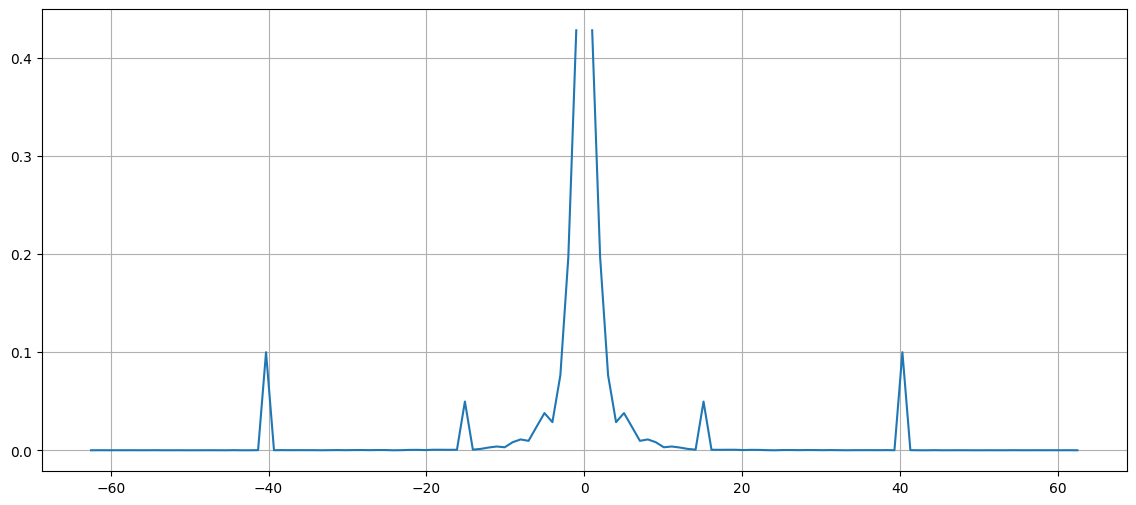

In [14]:
from scipy.fftpack import fft,ifft,fftshift

noise = N[:125] # Let's only extract 125 samples from N

Sf = fft(signal)
Nf = fft(noise)

n = len(signal)
T = 1.0
Sf[0] = None # Let's remove the DC component (0th frequency) for clarity!

fig = plt.figure(figsize=(14,6))
#plt.plot(np.linspace(-n*T/2,n*T/2,n), 1.0/n * np.abs(fftshift(Nf)))
#plt.plot(np.linspace(-n*T/2,n*T/2,n), 1.0/n * np.abs(fftshift(Sf)))
plt.plot(np.linspace(-n*T/2,n*T/2,n), 1.0/n * np.abs(fftshift(Sf+Nf)))

plt.grid()
plt.show()

The DFT (here calculated by the FFT-algorithm, the Fast Fourier Transform) gives us the two signals as a frequency plot. The plot is symmetric, so we can ignore any value less than zero ($x<0$). The x-axis indicates the frequency and the y-axis is roughly the signal power for that frequency (the plot shows the absolute values, since the transform will return complex values). We can see that the PPG-signal energy is concentrated at the lower frequencies spanning from 1 Hz up to about just over 10 Hz. The amount of power above 15 Hz is virtually zero.

The artificial noise has two peaks at 15 Hz and 40 Hz, which is exactly what we expected. The height of the peaks indicates the amplitude of the two sinusoid curves (divided by 2).

From this figure, we can see that a low-pass filter with a cut-off frequency somewhere in the region 10-15 Hz should filter out the noise and keep most of the original signal. However, how can we find a good filter that will do what we want?

**answer H**: Run the FFT on the signal with noise. How does it compare to the two FFT-curves of the signal and the noise?

Bonus question (only if you want): Can you design a low-pass filter for this in analogue electronics? What capacitance C, resistance R, and what order would you suggest?

## FIR Filter design

The ideal low-pass filter that filters out everything above a certain threshold does not really exist. Unless we are willing to use a FIR filter with an infinitely long list of coefficients ($h_k$). Hence, we always need to make compromises and that is the task of filter design.

Fortunately, many have developed several methods for efficient filter design so that you do not have to guess filter coefficients. On the following website, we have one option that creates a list of coefficients for a FIR filter based on a few configuration parameters: <a href="http://t-filter.engineerjs.com/">TFilter website</a>

In this exercise, try the web tool to find coefficients. Then paste them into the list below (don't forget commas between values in Python). Can you obtain the original non-noise curve by filtering out the noise? Try your best by modifying the configuration parameters. Try to minimize the length of the filter coefficient list (i.e., minimize the "number of taps").

To get you started with the web site. First make sure that you select low-pass filter in the drop-box in the lower left part. Then selected the sample frequency of 125 Hz. Finally select the pass band with gain 1 to range between 0-10 Hz and the stop band between 15-62.5 Hz (the Nyquist frequency of fs/2). Select a fixed number of taps, such as 7. Click 'DESIGN FILTER', which will use an iterative approach to find a good filter automatically for you. The graph will display the filter frequency response. This graph is similar to the DFT above, but only showing the positive frequency values from 0 to fs/125 = 62.5 Hz.

In the right column, you can select 'plain text' in the dropbox. Copy the coefficients into the Python code below into the $h$ array. Don't forget commas between values in Python. Run the code to see how the filter works on the sampled values. Perhaps there are still noise remaining, maybe the amplitudes are wrong.

**answer I**: Try to fix this by modifying the values in the website and try again and again, and again, until you are able to nearly recover the original curve without the noise. Include the plot in your report. How many taps do you need?

**answer J**: Try to reduce the number of taps to see what happens. Make sure not to amplify or attenuate the sought signal.

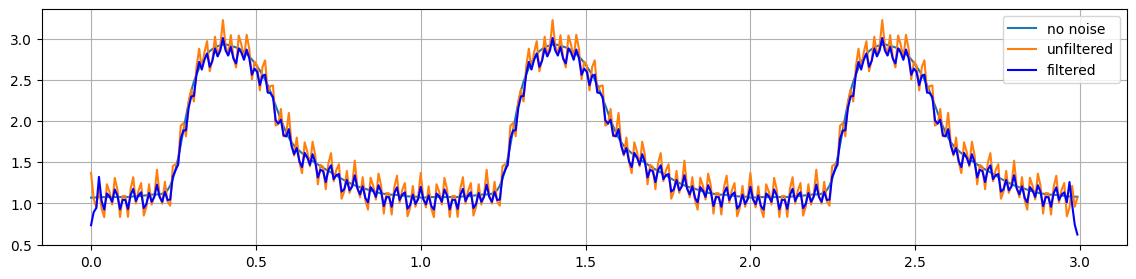

In [32]:
#h = np.array([1,1,1])/3
h = np.array([

-0.05705622301777374,
-0.15900893152245898,
0.24985960313453884,
0.15271008938670413,
0.20108279369837412,
0.199365174427649,
0.20108279369837412,
0.15271008938670413,
0.24985960313453884,
-0.15900893152245898,
-0.05705622301777374

 ])

y = np.convolve(S+N, h, mode='same')

# Draw the original signal, signal with noise, and the filtered signal
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.set_aspect(0.25)
plt.plot(X,S,'-', label='no noise')
plt.plot(X,S+N,'-', label='unfiltered')
plt.plot(X,y,'-', color='b', label='filtered')
ax.legend(loc='upper right')
plt.grid()
plt.show()

The package SciPy for Python also have functionality to design FIR filters. One approach is called the window method. There are many different approaches to window. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.get_window.html

In the script below, you can select the number of taps, the cutoff frequency, and the window type. Again try a few configurations to see if you can an acceptable result. Below, you will see the generated filter coefficients, the frequency response of the filter, and also how the filtered signal will look like.

**answer K**: Can you find a filter with similar performance as above? Include in your report the plot and the parameters used in the signal.firwin() call.

h =  [0.01114508 0.07453799 0.24282846 0.34297693 0.24282846 0.07453799
 0.01114508]


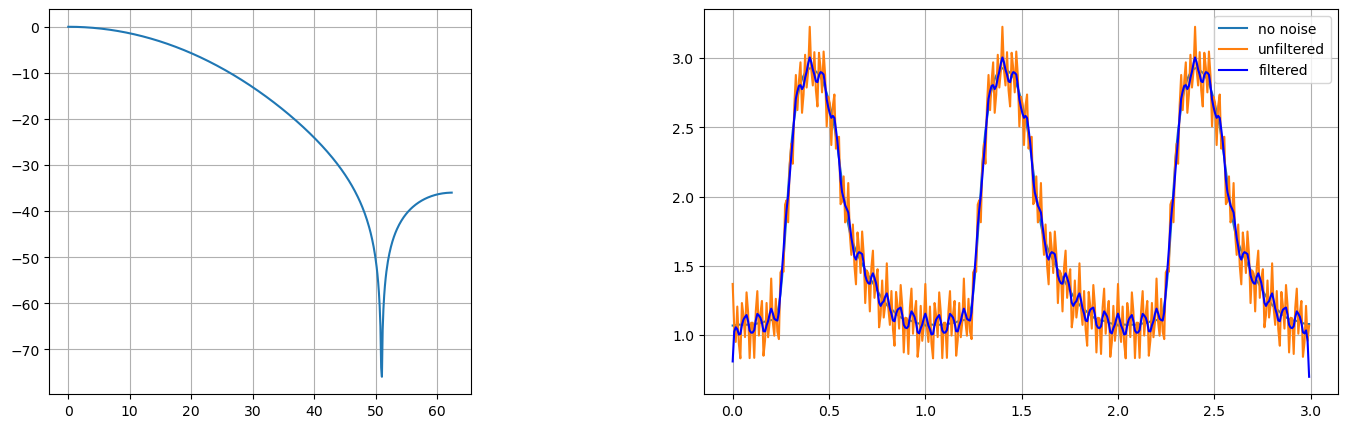

In [ ]:
from scipy import signal

numtaps = 7
cutoff = 14 #Hz
win = 'hamming'
#win = ('kaiser', 8)

h = signal.firwin(numtaps, cutoff, window=win, fs=125)


print("h = ", h)

# This line creates the filter frequency response graph
w, yf = signal.freqz(h, fs=125)

# This lines applies the filter to the signal
y = np.convolve(S+N, h, mode='same')

fig1, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 5))
ax1.set_aspect(0.75)
ax1.plot(w, 20 * np.log10(abs(yf)))
ax1.grid()
ax2.set_adjustable('datalim')
ax2.plot(X,S,'-', label='no noise')
ax2.plot(X,S+N,'-', label='unfiltered')
ax2.plot(X,y,'-', color='b', label='filtered')
ax2.legend(loc='upper right')
ax2.grid()
plt.show()

Finally, let's check the frequency response of the basic FIR filters that you manually made above. How good are they in filtering out the unwanted frequencies?

**Answer L** Draw the frequency response curves for the moving average filters of different lengths. Also draw it for the other examples above.

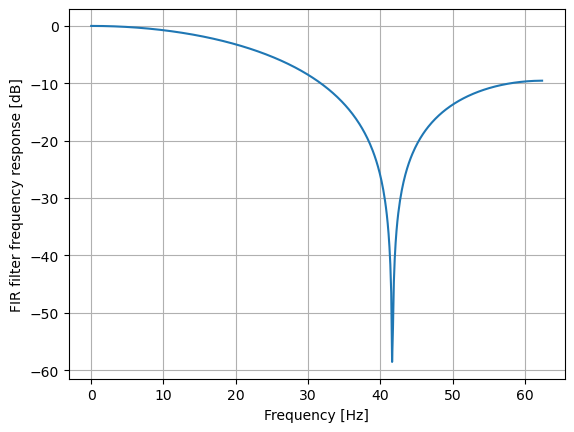

In [ ]:
from scipy import signal

h = np.array([1,1,1])/3.0
#h = np.ones(50)/50.0
#h = np.array([1,-1])

w, h = signal.freqz(h, fs=125)

plt.plot(w, 20 * np.log10(abs(h)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('FIR filter frequency response [dB]')
plt.grid()
plt.show()

# IIR Filter Design

EWMA is the simplest form of an Infinite Impulse Response (IIR) filter. Let's review the equation once again:

$$ y_n = \alpha x_n + (1-\alpha)y_{n-1} $$

We can calculate the frequency response and the cutoff frequency as well using Python.

**Answer M** What is the cut-off frequency for the EWMA that you used in Lab 1? Answer for both the smoothed signal and the "average"-curve.  Also estimate the sampling frequency `fs` that your Lab 1 solution actually achieved. Make sure to indicate in your answer: `fs` and the $\alpha$-values that you used.

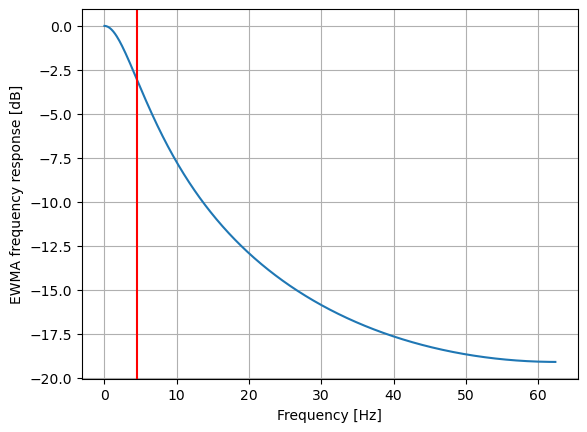

In [ ]:
alpha = 0.2
fs = 125 # Hertz, fill in the sampling frequency you achieved in Lab 1

w, h = scipy.signal.freqz([alpha], [1, alpha-1], fs=fs)

x = (alpha**2 + 2*alpha - 2) / (2*alpha - 2)
w_c = math.acos(x) * 125/2.0/math.pi

plt.plot(w, 20 * np.log10(abs(h)))
plt.axvline(w_c, color='red')
plt.xlabel('Frequency [Hz]')
plt.ylabel('EWMA frequency response [dB]')
plt.grid()
plt.show()

Now, let's apply the EWMA to our signal. First only the smoothing of the signal value. Adjust the $\alpha$-values here to achieve similar curves to Lab 1. Note that you need smaller $\alpha$-values here, since we have a higher sampling frequency!

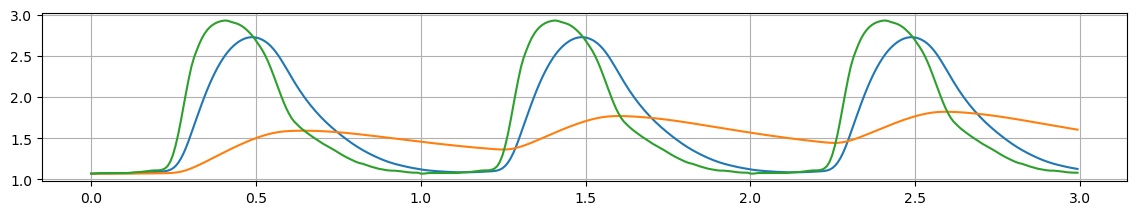

In [ ]:
def EWMA(signal, alpha):
    y = [signal[0]]
    for n in range(1, len(signal)):
        yn = alpha * signal[n] + (1 - alpha) * y[n - 1]
        y.append(yn)
    return np.array(y)

S_smoothed = EWMA(S, 0.1)
S_average = EWMA(S, 0.01)

fig = plt.figure(figsize=(14,6))
plt.axes().set_aspect(0.25)
plt.plot(X,S_smoothed,'-')
plt.plot(X,S_average,'-')
plt.plot(X,S,'-')
plt.grid()
plt.show()

**Answer N** Add the noise (N) to the original signal and apply the EWMA and show that you can remove most of the noise for both the "average"-curve and the smoothed signal. Include the diagram in your answer.

# The Filter function

We can now combine the FIR and IIR formulas into one, and then we obtain the filter function:

$$y_n = \sum_{i=0}^P a_ix_{n-i} + \sum_{i=1}^Q a_iy_{n-i}$$

We can then specify any IIR, FIR, or combination filter using only the parameters $a_i$ and $b_i$.

Filter design functions can automatically generate $a_i$ and $b_i$ from specified requirements, such as the order (number of $a_i$ and $b_i$ parameters), cut-off frequency, minimum attenuation in the stop band, etc. Let's try the Butterworth and Chebyshev type II filter designs:

b =  [0.43284664 1.73138658 2.59707987 1.73138658 0.43284664]
a =  [1.         2.36951301 2.31398841 1.05466541 0.18737949]


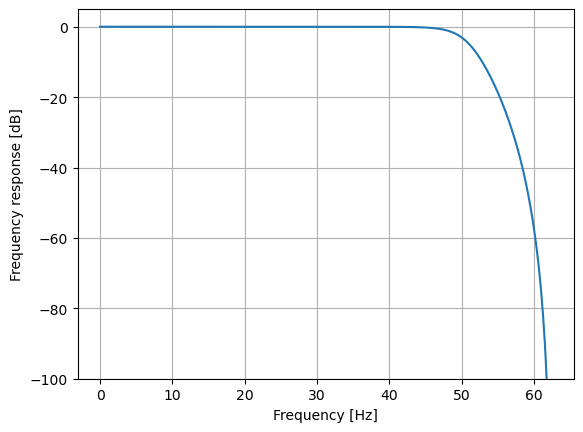

In [ ]:
b,a = scipy.signal.butter(4, 50, btype='lowpass', analog=False, fs=125, output='ba')
#b,a = scipy.signal.cheby2(4, 40, 15, btype='lowpass', analog=False, fs=125, output='ba')

print("b = ", b)
print("a = ", a)

w, h = scipy.signal.freqz(b, a, fs=125)

plt.plot(w, 20 * np.log10(abs(h)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Frequency response [dB]')
plt.ylim(-100, 5)
plt.grid()
plt.show()

**Answer O** Design a Chebyshev type II and a Butterworth filter that can preserve our PPG signal (0-10 Hz) and attenuate the noise (15 Hz and 40 Hz) by at least -30 dB. What arguments to the `butter()` and `cheby2()` functions did you use? Include the frequency response charts in your answer.

Finally, let's apply our designed filter to the signal+noise:

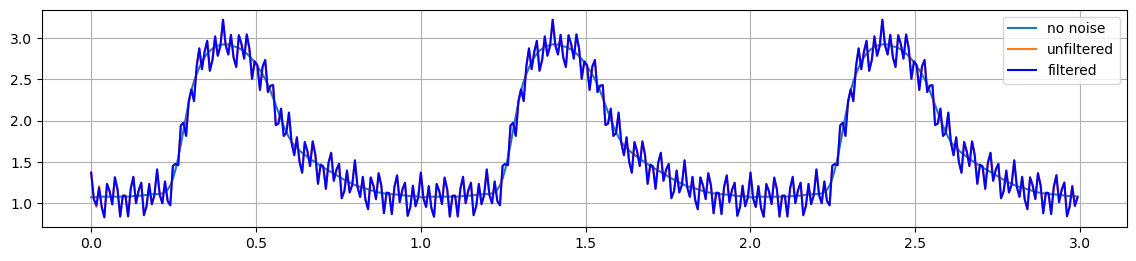

In [ ]:
y = scipy.signal.filtfilt(b, a, S+N)

# Draw the original signal, signal with noise, and the filtered signal
fig = plt.figure(figsize=(14,6))
ax = plt.axes()
ax.set_aspect(0.25)
plt.plot(X,S,'-', label='no noise')
plt.plot(X,S+N,'-', label='unfiltered')
plt.plot(X,y,'-', color='b', label='filtered')
ax.legend(loc='upper right')
plt.grid()
plt.show()

# Thanks for today!